# Inicialização

## Prepara o ambiente local ou colab

In [35]:
# --- Detectar Ambiente (Colab ou Local) ---
IN_COLAB = False
try:
    # Tenta importar um módulo específico do Colab
    from google.colab import drive
    import shutil # Usaremos para copiar, se necessário, mas salvar direto é melhor
    import os

    try:
        drive.mount('/content/drive')
        # Crie um diretório específico para salvar os resultados desta execução
        save_base_dir = "/content/drive/MyDrive/GAN_Training_Results" # Ajuste o caminho como desejar
        os.makedirs(save_base_dir, exist_ok=True)
        # Opcional: Crie um subdiretório único para esta execução específica (ex: baseado em timestamp)
        # import datetime
        # timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        # save_dir = os.path.join(save_base_dir, f"run_{timestamp}")
        # os.makedirs(save_dir, exist_ok=True)
        # Por simplicidade, vamos usar o diretório base diretamente por enquanto
        save_dir = save_base_dir
        print(f"✅ Google Drive montado. Arquivos serão salvos em: {save_dir}")
    except Exception as e:
        print(f"⚠️ Erro ao montar o Google Drive: {e}")
        print("   Downloads diretos serão tentados, mas podem atrasar.")
        save_dir = "." # Salvar localmente se o Drive falhar
    IN_COLAB = True
    print("✅ Ambiente Google Colab detectado. Downloads automáticos (a cada 2 épocas) ativados.")
except ImportError:
    print("✅ Ambiente local detectado. Downloads automáticos desativados.")

import os

✅ Ambiente local detectado. Downloads automáticos desativados.


## Importa Pacotes

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets

## Modelo Classificador

In [35]:
class Net(nn.Module):
    def __init__(self, seed=None):
        if seed is not None:
          torch.manual_seed(seed)
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [37]:
class Net_Cifar(nn.Module):
    def __init__(self,seed=None):
        if seed is not None:
          torch.manual_seed(seed)
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Carrega Dados MNIST centralizado

In [ ]:
BATCH_SIZE = 128

In [ ]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the training and test datasets
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
trainset_reduzido = torch.utils.data.random_split(trainset, [1000, len(trainset) - 1000])[0]
# Create data loaders
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
trainloader_reduzido = DataLoader(trainset_reduzido, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE)

In [ ]:
import matplotlib.pyplot as plt

# parameters
num_classes = 10
samples_per_class = 5

# containers
class_counts = {i: 0 for i in range(num_classes)}
class_images = {i: [] for i in range(num_classes)}

# gather up to 5 images per class
for img, label in trainset:
    if class_counts[label] < samples_per_class:
        class_images[label].append(img)
        class_counts[label] += 1
    # stop early once we have enough of every class
    if all(count >= samples_per_class for count in class_counts.values()):
        break

# plot
fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(5, 10))
for digit in range(num_classes):
    for i in range(samples_per_class):
        ax = axes[digit, i]
        ax.imshow(class_images[digit][i].squeeze(), cmap='gray')
        ax.axis('off')
    # label the rows on the leftmost subplot
    axes[digit, 0].set_ylabel(str(digit), rotation=0, labelpad=12, va='center', fontsize=12)

plt.suptitle("5 MNIST examples per digit (0–9)", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.97])
plt.show()


## Modelo Generativo

In [38]:
import numpy as np

### CGAN (simples, mlp)

In [ ]:
class CGAN(nn.Module):
    def __init__(self, dataset="mnist", img_size=28, latent_dim=100):
        super(CGAN, self).__init__()
        if dataset == "mnist":
            self.classes = 10
            self.channels = 1
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.img_shape = (self.channels, self.img_size, self.img_size)
        self.label_embedding = nn.Embedding(self.classes, self.classes)
        self.adv_loss = torch.nn.BCELoss()


        self.generator = nn.Sequential(
            *self._create_layer_gen(self.latent_dim + self.classes, 128, False),
            *self._create_layer_gen(128, 256),
            *self._create_layer_gen(256, 512),
            *self._create_layer_gen(512, 1024),
            nn.Linear(1024, int(np.prod(self.img_shape))),
            nn.Tanh()
        )

        self.discriminator = nn.Sequential(
            *self._create_layer_disc(self.classes + int(np.prod(self.img_shape)), 1024, False, True),
            *self._create_layer_disc(1024, 512, True, True),
            *self._create_layer_disc(512, 256, True, True),
            *self._create_layer_disc(256, 128, False, False),
            *self._create_layer_disc(128, 1, False, False),
            nn.Sigmoid()
        )

    def _create_layer_gen(self, size_in, size_out, normalize=True):
        layers = [nn.Linear(size_in, size_out)]
        if normalize:
            layers.append(nn.BatchNorm1d(size_out))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def _create_layer_disc(self, size_in, size_out, drop_out=True, act_func=True):
        layers = [nn.Linear(size_in, size_out)]
        if drop_out:
            layers.append(nn.Dropout(0.4))
        if act_func:
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def forward(self, input, labels):
        if input.dim() == 2:
            z = torch.cat((self.label_embedding(labels), input), -1)
            x = self.generator(z)
            x = x.view(x.size(0), *self.img_shape) #Em
            return x
        elif input.dim() == 4:
            x = torch.cat((input.view(input.size(0), -1), self.label_embedding(labels)), -1)
            return self.discriminator(x)

    def loss(self, output, label):
        return self.adv_loss(output, label)


### Arquitetura do paper F2U

In [39]:
class F2U_GAN(nn.Module):
    def __init__(self, dataset="mnist", img_size=28, latent_dim=128, condition=True, seed=None):
        if seed is not None:
          torch.manual_seed(seed)
        super(F2U_GAN, self).__init__()
        if dataset == "mnist":
            self.classes = 10
            self.channels = 1
        else:
            raise NotImplementedError("Only MNIST is supported")

        self.condition = condition
        self.label_embedding = nn.Embedding(self.classes, self.classes) if condition else None
        #self.label_embedding_disc = nn.Embedding(self.classes, self.img_size*self.img_size) if condition else None
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.img_shape = (self.channels, self.img_size, self.img_size)
        self.input_shape_gen = self.latent_dim + self.label_embedding.embedding_dim if condition else self.latent_dim
        self.input_shape_disc = self.channels + self.classes if condition else self.channels

        self.adv_loss = torch.nn.BCEWithLogitsLoss()

        # Generator (unchanged) To calculate output shape of convtranspose layers, we can use the formula:
        # output_shape = (input_shape - 1) * stride - 2 * padding + kernel_size + output_padding (or dilation * (kernel_size - 1) + 1 inplace of kernel_size if using dilation)
        self.generator = nn.Sequential(
            nn.Linear(self.input_shape_gen, 256 * 7 * 7),
            nn.ReLU(inplace=True),
            nn.Unflatten(1, (256, 7, 7)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # (256,7,7) -> (128,14,14)
            nn.BatchNorm2d(128, momentum=0.1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), # (128,14,14) -> (64,28,28)
            nn.BatchNorm2d(64, momentum=0.1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, self.channels, kernel_size=3, stride=1, padding=1), # (64,28,28) -> (1,28,28)
            nn.Tanh()
        )

        # Discriminator (corrected) To calculate output shape of conv layers, we can use the formula:
        # output_shape = ⌊(input_shape - kernel_size + 2 * padding) / stride + 1⌋ (or (dilation * (kernel_size - 1) - 1) inplace of kernel_size if using dilation)
        self.discriminator = nn.Sequential(
        # Camada 1: (1,28,28) -> (32,13,13)
        nn.utils.spectral_norm(nn.Conv2d(self.input_shape_disc, 32, kernel_size=3, stride=2, padding=0)),
        nn.LeakyReLU(0.2, inplace=True),

        # Camada 2: (32,14,14) -> (64,7,7)
        nn.utils.spectral_norm(nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)),
        nn.LeakyReLU(0.2, inplace=True),

        # Camada 3: (64,7,7) -> (128,3,3)
        nn.utils.spectral_norm(nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=0)),
        nn.LeakyReLU(0.2, inplace=True),

        # Camada 4: (128,3,3) -> (256,1,1)
        nn.utils.spectral_norm(nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=0)),  # Padding 0 aqui!
        nn.LeakyReLU(0.2, inplace=True),

        # Achata e concatena com as labels
        nn.Flatten(), # (256,1,1) -> (256*1*1,)
        nn.utils.spectral_norm(nn.Linear(256 * 1 * 1, 1))  # 256 (features)
        )

    def forward(self, input, labels=None):
        if input.dim() == 2:
            # Generator forward pass (unchanged)
            if self.condition:
                embedded_labels = self.label_embedding(labels)
                gen_input = torch.cat((input, embedded_labels), dim=1)
                x = self.generator(gen_input)
            else:
                x = self.generator(input)
            return x.view(-1, *self.img_shape)

        elif input.dim() == 4:
            # Discriminator forward pass
            if self.condition:
                embedded_labels = self.label_embedding(labels)
                image_labels = embedded_labels.view(embedded_labels.size(0), self.label_embedding.embedding_dim, 1, 1).expand(-1, -1, self.img_size, self.img_size)
                x = torch.cat((input, image_labels), dim=1)
            else:
                x = input
            return self.discriminator(x)

    def loss(self, output, label):
        return self.adv_loss(output, label)

In [40]:
class F2U_GAN_CIFAR(nn.Module):
    def __init__(self, img_size=32, latent_dim=128, condition=True, seed=None):
        if seed is not None:
          torch.manual_seed(seed)
        super(F2U_GAN_CIFAR, self).__init__()
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.classes = 10
        self.channels = 3
        self.condition = condition

        # Embedding para condicionamento
        self.label_embedding = nn.Embedding(self.classes, self.classes) if self.condition else None

        # Shapes de entrada
        self.input_shape_gen = self.latent_dim + (self.classes if self.condition else 0)
        self.input_shape_disc = self.channels + (self.classes if self.condition else 0)

        # -----------------
        #  Generator
        # -----------------
        self.generator = nn.Sequential(
            nn.Linear(self.input_shape_gen, 512 * 4 * 4),
            nn.ReLU(inplace=True),
            nn.Unflatten(1, (512, 4, 4)),                  # → (512,4,4)

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # → (256,8,8)
            nn.BatchNorm2d(256, momentum=0.1),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # → (128,16,16)
            nn.BatchNorm2d(128, momentum=0.1),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128,  64, kernel_size=4, stride=2, padding=1),  # → ( 64,32,32)
            nn.BatchNorm2d(64,  momentum=0.1),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d( 64,   self.channels, kernel_size=3, stride=1, padding=1),  # → (3,32,32)
            nn.Tanh()
        )

        # -----------------
        #  Discriminator
        # -----------------
        layers = []
        in_ch = self.input_shape_disc
        cfg = [
            ( 64, 3, 1),  # → spatial stays 32
            ( 64, 4, 2),  # → 16
            (128, 3, 1),  # → 16
            (128, 4, 2),  # → 8
            (256, 4, 2),  # → 4
        ]
        for out_ch, k, s in cfg:
            layers += [
                nn.utils.spectral_norm(
                    nn.Conv2d(in_ch, out_ch, kernel_size=k, stride=s, padding=1)
                ),
                nn.LeakyReLU(0.1, inplace=True)
            ]
            in_ch = out_ch

        layers += [
            nn.Flatten(),
            nn.utils.spectral_norm(
                nn.Linear(256 * 4 * 4, 1)
            )
        ]
        self.discriminator = nn.Sequential(*layers)

        # adversarial loss
        self.adv_loss = nn.BCEWithLogitsLoss()

    def forward(self, input, labels=None):
        # Generator pass
        if input.dim() == 2 and input.size(1) == self.latent_dim:
            if self.condition:
                if labels is None:
                    raise ValueError("Labels must be provided for conditional generation")
                embedded = self.label_embedding(labels)
                gen_input = torch.cat((input, embedded), dim=1)
            else:
                gen_input = input
            img = self.generator(gen_input)
            return img

        # Discriminator pass
        elif input.dim() == 4 and input.size(1) == self.channels:
            x = input
            if self.condition:
                if labels is None:
                    raise ValueError("Labels must be provided for conditional discrimination")
                embedded = self.label_embedding(labels)
                # criar mapa de labels e concatenar
                lbl_map = embedded.view(-1, self.classes, 1, 1).expand(-1, self.classes, self.img_size, self.img_size)
                x = torch.cat((x, lbl_map), dim=1)
            return self.discriminator(x)

        else:
            raise ValueError("Input shape not recognized")

    def loss(self, logits, targets):
        return self.adv_loss(logits.view(-1), targets.float().view(-1))


## Funções para geração de dataset e imagens

In [41]:
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import random # Needed for handling remainders if samples aren't perfectly divisible

class GeneratedDataset(Dataset):
    def __init__(self,
                 generator,
                 num_samples,
                 latent_dim=100,
                 num_classes=10, # Total classes the generator model knows
                 desired_classes=None, # Optional: List of specific class indices to generate
                 device="cpu",
                 image_col_name="image",
                 label_col_name="label"):
        """
        Generates a dataset using a conditional generative model, potentially
        focusing on a subset of classes.

        Args:
            generator: The pre-trained generative model.
            num_samples (int): Total number of images to generate across the desired classes.
            latent_dim (int): Dimension of the latent space vector (z).
            num_classes (int): The total number of classes the generator was trained on.
                               This is crucial for correct label conditioning (e.g., one-hot dim).
            desired_classes (list[int], optional): A list of integer class indices to generate.
                                                  If None or empty, images for all classes
                                                  (from 0 to num_classes-1) will be generated,
                                                  distributed as evenly as possible.
                                                  Defaults to None.
            device (str): Device to run generation on ('cpu' or 'cuda').
            image_col_name (str): Name for the image column in the output dictionary.
            label_col_name (str): Name for the label column in the output dictionary.
        """
        self.generator = generator
        self.num_samples = num_samples
        self.latent_dim = latent_dim
        # Store the total number of classes the generator understands
        self.total_num_classes = num_classes
        self.device = device
        self.model_type = type(self.generator).__name__ # Get generator class name
        self.image_col_name = image_col_name
        self.label_col_name = label_col_name

        # Determine the actual classes to generate based on desired_classes
        if desired_classes is not None and len(desired_classes) > 0:
            # Validate that desired classes are within the generator's known range
            if not all(0 <= c < self.total_num_classes for c in desired_classes):
                raise ValueError(f"All desired classes must be integers between 0 and {self.total_num_classes - 1}")
            # Use only the unique desired classes, sorted for consistency
            self._actual_classes_to_generate = sorted(list(set(desired_classes)))
        else:
            # If no specific classes desired, generate all classes
            self._actual_classes_to_generate = list(range(self.total_num_classes))

        # The 'classes' attribute of the dataset reflects only those generated
        self.classes = self._actual_classes_to_generate
        self.num_generated_classes = len(self.classes) # Number of classes being generated

        if self.num_generated_classes == 0 and self.num_samples > 0:
             raise ValueError("Cannot generate samples with an empty list of desired classes.")
        elif self.num_samples == 0:
             print("Warning: num_samples is 0. Dataset will be empty.")
             self.images = torch.empty(0) # Adjust shape if known
             self.labels = torch.empty(0, dtype=torch.long)
        else:
             # Generate the data only if needed
             self.images, self.labels = self.generate_data()


    def generate_data(self):
        """Generates images and corresponding labels for the specified classes."""
        self.generator.eval()
        self.generator.to(self.device)

        # --- Create Labels ---
        generated_labels_list = []
        if self.num_generated_classes > 0:
            # Distribute samples as evenly as possible among the desired classes
            samples_per_class = self.num_samples // self.num_generated_classes
            for cls in self._actual_classes_to_generate:
                generated_labels_list.extend([cls] * samples_per_class)

            # Handle remaining samples if num_samples is not perfectly divisible
            num_remaining = self.num_samples - len(generated_labels_list)
            if num_remaining > 0:
                # Add remaining samples by randomly choosing from the desired classes
                remainder_labels = random.choices(self._actual_classes_to_generate, k=num_remaining)
                generated_labels_list.extend(remainder_labels)

            # Shuffle labels for better distribution in batches later
            random.shuffle(generated_labels_list)

        # Convert labels list to tensor
        labels = torch.tensor(generated_labels_list, dtype=torch.long, device=self.device)

        # Double check label count (should match num_samples due to logic above)
        if len(labels) != self.num_samples:
             # This indicates an unexpected issue, potentially if num_generated_classes was 0 initially
             # but num_samples > 0. Raise error or adjust. Let's adjust defensively.
             print(f"Warning: Label count mismatch. Expected {self.num_samples}, got {len(labels)}. Adjusting size.")
             if len(labels) > self.num_samples:
                 labels = labels[:self.num_samples]
             else:
                 # Pad if too few (less likely with current logic unless num_generated_classes=0)
                 num_needed = self.num_samples - len(labels)
                 if self.num_generated_classes > 0:
                      padding = torch.tensor(random.choices(self._actual_classes_to_generate, k=num_needed), dtype=torch.long, device=self.device)
                      labels = torch.cat((labels, padding))
                 # If no classes to generate from, labels tensor might remain smaller

        # --- Create Latent Noise ---
        z = torch.randn(self.num_samples, self.latent_dim, device=self.device)

        # --- Generate Images in Batches ---
        generated_images_list = []
        # Consider making batch_size configurable
        batch_size = min(1024, self.num_samples) if self.num_samples > 0 else 1

        with torch.no_grad():
            for i in range(0, self.num_samples, batch_size):
                z_batch = z[i : min(i + batch_size, self.num_samples)]
                labels_batch = labels[i : min(i + batch_size, self.num_samples)]

                # Skip if batch is empty (can happen if num_samples = 0)
                if z_batch.shape[0] == 0:
                    continue

                # --- Condition the generator based on its type ---
                if self.model_type == 'Generator': # Assumes input: concat(z, one_hot_label)
                    # One-hot encode labels using the TOTAL number of classes the generator knows
                    labels_one_hot_batch = F.one_hot(labels_batch, num_classes=self.total_num_classes).float()
                    generator_input = torch.cat([z_batch, labels_one_hot_batch], dim=1)
                    gen_imgs = self.generator(generator_input)
                elif self.model_type in ('CGAN', 'F2U_GAN', 'F2U_GAN_CIFAR'): # Assumes input: z, label_index
                    gen_imgs = self.generator(z_batch, labels_batch)
                else:
                    # Handle other potential generator architectures or raise an error
                    raise NotImplementedError(f"Generation logic not defined for model type: {self.model_type}")

                generated_images_list.append(gen_imgs.cpu()) # Move generated images to CPU

        self.generator.cpu() # Move generator back to CPU after generation

        # Concatenate all generated image batches
        if generated_images_list:
            all_gen_imgs = torch.cat(generated_images_list, dim=0)
        else:
            # If no images were generated (e.g., num_samples = 0)
            # Create an empty tensor. Shape needs care - determine from generator or use placeholder.
            # Let's attempt a placeholder [0, C, H, W] - requires knowing C, H, W.
            # For now, a simple empty tensor. User might need to handle this downstream.
            print("Warning: No images generated. Returning empty tensor for images.")
            all_gen_imgs = torch.empty(0)

        return all_gen_imgs, labels.cpu() # Return images and labels (on CPU)

    def __len__(self):
        # Return the actual number of samples generated
        return self.images.shape[0]

    def __getitem__(self, idx):
        if idx >= len(self):
            raise IndexError("Dataset index out of range")
        return {
            self.image_col_name: self.images[idx],
            self.label_col_name: int(self.labels[idx]) # Return label as standard Python int
        }


In [8]:
class UnconditionalGeneratedDataset(Dataset):
    def __init__(self,
                 generator,
                 num_samples,
                 latent_dim=128,
                 device="cpu",
                 image_col_name="image"):
        """
        Generates a dataset using an unconditional generative model.

        Args:
            generator: The pre-trained unconditional generative model.
            num_samples (int): Total number of images to generate.
            latent_dim (int): Dimension of the latent space vector (z).
            device (str): Device to run generation on ('cpu' or 'cuda').
            image_col_name (str): Name for the image column in the output dictionary.
        """
        self.generator = generator
        self.num_samples = num_samples
        self.latent_dim = latent_dim
        self.device = device
        self.image_col_name = image_col_name

        if self.num_samples < 0:
            raise ValueError("num_samples must be non-negative")
        elif self.num_samples == 0:
            print("Warning: num_samples is 0. Dataset will be empty.")
            self.images = torch.empty(0)
        else:
            self.images = self._generate_images()

    def _generate_images(self):
        self.generator.eval()
        self.generator.to(self.device)

        # Create latent noise
        z = torch.randn(self.num_samples, self.latent_dim, device=self.device)

        # Generate images in batches
        generated_images = []
        batch_size = min(1024, self.num_samples)
        with torch.no_grad():
            for i in range(0, self.num_samples, batch_size):
                z_batch = z[i : min(i + batch_size, self.num_samples)]
                gen_imgs = self.generator(z_batch)
                generated_images.append(gen_imgs.cpu())

        self.generator.cpu()
        return torch.cat(generated_images, dim=0)

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        if idx >= len(self):
            raise IndexError("Dataset index out of range")
        return { self.image_col_name: self.images[idx] }


In [42]:
def generate_plot(net, device, round_number, client_id = None, examples_per_class: int=5, classes: int=10, latent_dim: int=100):
    """Gera plot de imagens de cada classe"""

    net_type = type(net).__name__
    net.to(device)
    net.eval()
    batch_size = examples_per_class * classes
    dataset = "mnist" if  not net_type == "F2U_GAN_CIFAR" else "cifar10"

    latent_vectors = torch.randn(batch_size, latent_dim, device=device)
    labels = torch.tensor([i for i in range(classes) for _ in range(examples_per_class)], device=device)

    with torch.no_grad():
        if net_type == "Generator":
            labels_one_hot = torch.nn.functional.one_hot(labels, 10).float().to(device)
            generated_images = net(torch.cat([latent_vectors, labels_one_hot], dim=1))
        else:
            generated_images = net(latent_vectors, labels)

    # Criar uma figura com 10 linhas e 5 colunas de subplots
    fig, axes = plt.subplots(classes, examples_per_class, figsize=(5, 9))

    # Adiciona título no topo da figura
    if isinstance(client_id, int):
        fig.text(0.5, 0.98, f"Round: {round_number} | Client: {client_id}", ha="center", fontsize=12)
    else:
        fig.text(0.5, 0.98, f"Round: {round_number}", ha="center", fontsize=12)

    # Exibir as imagens nos subplots
    for i, ax in enumerate(axes.flat):
        if dataset == "mnist":
            ax.imshow(generated_images[i, 0, :, :], cmap='gray')
        else:
            images = (generated_images[i] + 1)/2
            ax.imshow(images.permute(1, 2, 0).clamp(0,1))
        ax.set_xticks([])
        ax.set_yticks([])

    # Ajustar o layout antes de calcular as posições
    plt.tight_layout(rect=[0.05, 0, 1, 0.96])

    # Reduzir espaço entre colunas
    # plt.subplots_adjust(wspace=0.05)

    # Adicionar os rótulos das classes corretamente alinhados
    fig.canvas.draw()  # Atualiza a renderização para obter posições corretas
    for row in range(classes):
        # Obter posição do subplot em coordenadas da figura
        bbox = axes[row, 0].get_window_extent(fig.canvas.get_renderer())
        pos = fig.transFigure.inverted().transform([(bbox.x0, bbox.y0), (bbox.x1, bbox.y1)])
        center_y = (pos[0, 1] + pos[1, 1]) / 2  # Centro exato da linha

        # Adicionar o rótulo
        fig.text(0.04, center_y, str(row), va='center', fontsize=12, color='black')

    IN_COLAB = False
    try:
        # Tenta importar um módulo específico do Colab
        import google.colab
        IN_COLAB = True
    except:
        pass

    if IN_COLAB:
        if isinstance(client_id, int):
            fig.savefig(os.path.join(save_dir, f"{dataset}_{net_type}_r{round_number}_c{client_id}.png"))
            print("Imagem do cliente salva no drive")
        else:
            fig.savefig(os.path.join(save_dir, f"{dataset}{net_type}_r{round_number}.png"))
            print("Imagem do servidor salva no drive")
    else:
        if isinstance(client_id, int):
            fig.savefig(f"{dataset}{net_type}_r{round_number}_c{client_id}.png")
            print("Imagem do cliente salva")
        else:
            fig.savefig(f"{dataset}{net_type}_r{round_number}.png")
            print("Imagem do servidor salva")
    plt.close(fig)
    return

In [10]:
def plot_unconditional_generated(
        generator,
        device,
        total_samples,
        samples_per_row=5,
        latent_dim=100,
        save_path=None,
        round_number=None):
    """
    Generates and plots images from an unconditional generator in a grid.

    Args:
        generator: The unconditional torch generator model (z -> image).
        device: Device to run generation on ('cpu' or 'cuda').
        total_samples (int): Number of images to generate.
        samples_per_row (int): Number of images per row in the grid.
        latent_dim (int): Dimension of latent vector.
        save_path (str, optional): Filepath to save the figure. If None, just shows plot.
    """

    generator.eval()
    generator.to(device)

    # Sample latent vectors
    z = torch.randn(total_samples, latent_dim, device=device)
    with torch.no_grad():
        imgs = generator(z)

    # Determine grid size
    cols = samples_per_row
    rows = math.ceil(total_samples / cols)

    # Create figure
    fig, axes = plt.subplots(rows, cols, figsize=(cols-2*cols/(rows+cols), rows-1*rows/(rows+cols)))
    axes = axes.flatten() if total_samples > 1 else [axes]

    fig.text(0.5, 0.99, f"Round: {round_number}", ha="center", fontsize=11)

    for idx in range(rows * cols):
        ax = axes[idx]
        ax.axis('off')
        if idx < total_samples:
            img = imgs[idx]
            # Assume (C, H, W) and single-channel
            ax.imshow(img[0], cmap='gray')

    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.savefig(save_path)
        print(f"Figure saved to {save_path}")
    else:
        plt.show()

    plt.close(fig)


## Importa Pacotes Federado

In [43]:
if IN_COLAB:
    !pip install flwr_datasets
    !pip install flwr

In [44]:
from flwr_datasets.partitioner import DirichletPartitioner, IidPartitioner
from flwr_datasets.visualization import plot_label_distributions
from flwr_datasets import FederatedDataset

## Particionador por classes

In [13]:
# Copyright 2023 Flower Labs GmbH. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Class-based partitioner for Hugging Face Datasets."""


from collections import defaultdict
import random
from typing import Optional, List
import numpy as np
from datasets import Dataset
from flwr_datasets.partitioner.partitioner import Partitioner  # Assuming this is in the package structure


class ClassPartitioner(Partitioner):
    """Partitions a dataset by class, ensuring each class appears in exactly one partition.

    Attributes:
        num_partitions (int): Total number of partitions to create
        seed (int, optional): Random seed for reproducibility
        label_column (str): Name of the column containing class labels
    """

    def __init__(
        self,
        num_partitions: int,
        seed: Optional[int] = None,
        label_column: str = "label"
    ) -> None:
        super().__init__()
        self._num_partitions = num_partitions
        self._seed = seed
        self._label_column = label_column
        self._partition_indices: Optional[List[List[int]]] = None

    def _create_partitions(self) -> None:
        """Create class-based partitions and store indices."""
        # Extract labels from dataset
        labels = self.dataset[self._label_column]

        # Group indices by class
        class_indices = defaultdict(list)
        for idx, label in enumerate(labels):
            class_indices[label].append(idx)

        classes = list(class_indices.keys())
        num_classes = len(classes)

        # Validate number of partitions
        if self._num_partitions > num_classes:
            raise ValueError(
                f"Cannot create {self._num_partitions} partitions with only {num_classes} classes. "
                f"Reduce partitions to ≤ {num_classes}."
            )

        # Shuffle classes for random distribution
        rng = random.Random(self._seed)
        rng.shuffle(classes)

        # Split classes into partitions
        partition_classes = np.array_split(classes, self._num_partitions)

        # Create index lists for each partition
        self._partition_indices = []
        for class_group in partition_classes:
            indices = []
            for cls in class_group:
                indices.extend(class_indices[cls])
            self._partition_indices.append(indices)

    @property
    def dataset(self) -> Dataset:
        return super().dataset

    @dataset.setter
    def dataset(self, value: Dataset) -> None:
        # Use parent setter for basic validation
        super(ClassPartitioner, ClassPartitioner).dataset.fset(self, value)

        # Create partitions once dataset is set
        self._create_partitions()

    def load_partition(self, partition_id: int) -> Dataset:
        """Load a partition containing exclusive classes.

        Args:
            partition_id: The ID of the partition to load (0-based index)

        Returns:
            Dataset: Subset of the dataset containing only the specified partition's data
        """
        if not self.is_dataset_assigned():
            raise RuntimeError("Dataset must be assigned before loading partitions")
        if partition_id < 0 or partition_id >= self.num_partitions:
            raise ValueError(f"Invalid partition ID: {partition_id}")

        return self.dataset.select(self._partition_indices[partition_id])

    @property
    def num_partitions(self) -> int:
        return self._num_partitions

    def __repr__(self) -> str:
        return (f"ClassPartitioner(num_partitions={self._num_partitions}, "
                f"seed={self._seed}, label_column='{self._label_column}')")

## Carrega e divide dados entre clientes

In [45]:
num_partitions = 4
alpha_dir = 0.5

Rodar somente o particionador desejado

In [15]:
partitioner = ClassPartitioner(num_partitions=num_partitions, seed=42, label_column="label")

In [46]:
partitioner = DirichletPartitioner(
    num_partitions=num_partitions,
    partition_by="label",
    alpha=alpha_dir,
    min_partition_size=0,
    self_balancing=False
)

In [ ]:
partitioner = IidPartitioner(
    num_partitions=num_partitions
)

In [16]:
fds = FederatedDataset(
    dataset="mnist",
    partitioners={"train": partitioner}
)

In [47]:
fds = FederatedDataset(
    dataset="cifar10",
    partitioners={"train": partitioner}
)

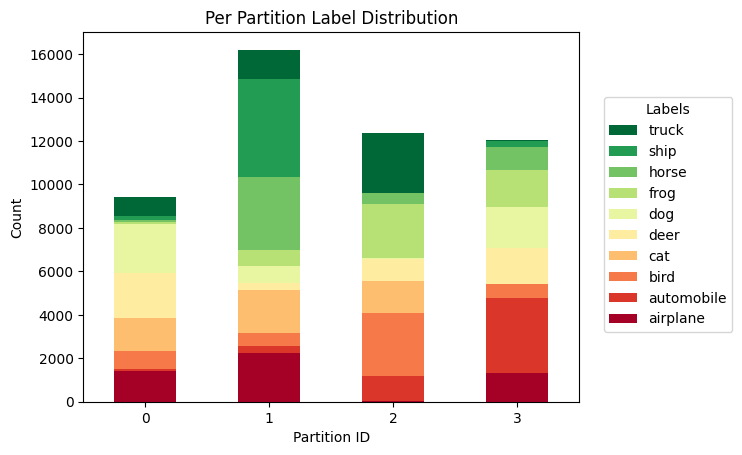

In [48]:
partitioner = fds.partitioners["train"]
figure, axis, dataframe = plot_label_distributions(
    partitioner=partitioner,
    label_name="label",
    title="Per Partition Label Distribution",
    legend=True,
    verbose_labels=True,
    size_unit="absolute",
    partition_id_axis="x",
)

In [49]:
train_partitions = [fds.load_partition(i, split="train") for i in range(num_partitions)]

Rodar proxima celula somente se quiser testar com dataset reduzido

In [ ]:
# num_samples = [int(len(train_partition)/10) for train_partition in train_partitions]
# train_partitions = [train_partition.select(range(n)) for train_partition, n in zip(train_partitions, num_samples)]

Cria dicionario de label para cliente para controle do dmax_mismatch. Tive que colocar aqui antes do apply_transform para não dar erro.

In [50]:
from collections import Counter

In [51]:
min_lbl_count = 0.05
class_labels = train_partitions[0].info.features["label"]
labels_str = class_labels.names
label_to_client = {lbl: [] for lbl in labels_str}
for idx, ds in enumerate(train_partitions):
    counts = Counter(ds['label'])
    for label, cnt in counts.items():
        if cnt / len(ds) >= min_lbl_count:
            label_to_client[class_labels.int2str(label)].append(idx)

In [52]:
from torchvision.transforms import Compose, ToTensor, Normalize

In [23]:
pytorch_transforms = Compose([
    ToTensor(),
    Normalize((0.5,), (0.5,))
])

def apply_transforms(batch):
    batch["image"] = [pytorch_transforms(img) for img in batch["image"]]
    return batch

In [53]:
# Para CIFAR-10: 3 canais, normalização média=0.5 e std=0.5
pytorch_transforms = Compose([
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def apply_transforms(batch):
    # batch["image"] é uma lista de PIL.Image ou tensores em H×W×C
    # aplicamos o mesmo transform a cada imagem e depois empilhamos
    batch["img"] = torch.stack([pytorch_transforms(img) for img in batch["img"]])
    return batch

In [54]:
train_partitions = [train_partition.with_transform(apply_transforms) for train_partition in train_partitions]

c:\Users\55199\AppData\Local\Programs\Python\Python313\Lib\site-packages\datasets\utils\_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


In [20]:
from torch.utils.data import random_split

In [55]:
test_frac = 0.2
client_datasets = []

for train_part in train_partitions:
    total     = len(train_part)
    test_size = int(total * test_frac)
    train_size = total - test_size

    client_train, client_test = random_split(
        train_part,
        [train_size, test_size],
        generator=torch.Generator().manual_seed(42),
    )

    client_datasets.append({
        "train": client_train,
        "test":  client_test,
    })


## Inicializa modelos e otimizadores

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Rodar somente o modelo desejado

In [ ]:
models = [CGAN() for i in range(num_partitions)]
gen = CGAN().to(device)
optim_G = torch.optim.Adam(gen.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [28]:
models = [F2U_GAN(condition=True) for i in range(num_partitions)]
gen = F2U_GAN(condition=True).to(device)
optim_G = torch.optim.Adam(gen.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [57]:
models = [F2U_GAN_CIFAR(condition=True, seed=42) for i in range(num_partitions)]
gen = F2U_GAN_CIFAR(condition=True, seed=42).to(device)
optim_G = torch.optim.Adam(gen.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [58]:
optim_Ds = [
    torch.optim.Adam(model.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    for model in models
]

# scheduler_D = torch.optim.lr_scheduler.StepLR(optim_D, step_size=5, gamma=0.9)
# scheduler_G = torch.optim.lr_scheduler.StepLR(optim_G, step_size=5, gamma=0.9)

Inicializa lambda para F2A

In [ ]:
# initial λ* (unconstrained), wrap with ReLU to keep λ ≥ 0
lambda_star = nn.Parameter(torch.tensor(0.1, device=device))
relu = nn.ReLU()

beta = 0.1  # same β as in the paper

# now make your generator optimizer also update lambda_star
# (so its gradient from the βλ² term can flow)
optim_G = torch.optim.Adam(
    list(gen.parameters()) + [lambda_star],
    lr=2e-4, betas=(0.5, 0.999)
)

# Treinamento dos modelos

## Cria chunks para o treinamento alternado entre discriminadora e geradora ser mais constante.

In [25]:
import math
from torch.utils.data import Subset

Quanto menos chunks, mais dados em cada chunk e mais dados são treinados na discriminadora antes de treinar a geradora. No paper do F2U, não está claro como os treinamentos são alternados.

In [ ]:
# prompt: set each train partition as the only first minimum lenght of the partitions samples, the partitions have same lenght

min_len = min(len(p) for p in train_partitions)
train_partitions = [p.select(range(min_len)) for p in train_partitions]


In [ ]:
for train_partition in train_partitions:
  print(len(train_partition))

In [59]:
num_chunks = 100
client_chunks = []
for train_partition in client_datasets:
  chunk_size = math.ceil(len(train_partition["train"])/num_chunks)

  chunks = []
  for i in range(num_chunks):
      start = i * chunk_size
      end = min((i + 1) * chunk_size, len(train_partition["train"]))
      chunks.append(Subset(train_partition["train"], range(start, end)))

  client_chunks.append(chunks)

In [27]:
from torch.utils.data import DataLoader

In [60]:
batch_size = 64
client_test_loaders = [DataLoader(dataset=ds["test"], batch_size=batch_size, shuffle=False) for ds in client_datasets]

In [ ]:
def make_model():
    # (re)seed PyTorch’s RNG for both CPU and all GPUs
    torch.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    # (optionally) enforce deterministic CuDNN behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # now construct the model
    model = MyNetwork(...)
    return model

# both of these will have identical initial parameters:
model1 = make_model()
model2 = make_model()

## Treinamento

In [61]:
nets = [Net_Cifar(42).to(device) for _ in range(num_partitions)]
optims = [torch.optim.Adam(net.parameters(), lr=0.01) for net in nets]
criterion = torch.nn.CrossEntropyLoss()

In [62]:
testpartition = fds.load_split("test")
testpartition = testpartition.with_transform(apply_transforms)
testloader = DataLoader(testpartition, batch_size=64)

c:\Users\55199\AppData\Local\Programs\Python\Python313\Lib\site-packages\datasets\utils\_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Carregar modelo pré-treinado

In [63]:
global_net = Net_Cifar(42).to(device)

In [ ]:
checkpoint_loaded = torch.load("../Experimentos/GeraFed_4c_01Dir/CIFAR/checkpoint_epoch35.pth")

global_net.load_state_dict(checkpoint_loaded['alvo_state_dict'])
global_net.to(device)
for optim, state in zip(optims, checkpoint_loaded['optimizer_alvo_state_dict']):
    optim.load_state_dict(state)

gen.load_state_dict(checkpoint_loaded["gen_state_dict"])
gen.to(device)
optim_G.load_state_dict(checkpoint_loaded["optim_G_state_dict"])

for model, optim_d, state_model, state_optim in zip(models, optim_Ds, checkpoint_loaded["discs_state_dict"], checkpoint_loaded["optim_Ds_state_dict:"]):
    model.load_state_dict(state_model)
    model.to(device)
    optim_d.load_state_dict(state_optim)

Não esquecer de reinicializar os modelos e otimizadores se for reinicializar o treinamento.

In [64]:
from flwr.server.strategy.aggregate import aggregate_inplace
from flwr.common import FitRes, Status, Code, ndarrays_to_parameters
from collections import OrderedDict, defaultdict
from torch.utils.data import ConcatDataset
import time
from tqdm.notebook import tqdm
import os
import json
import matplotlib.pyplot as plt

In [ ]:
wgan = False
f2a = False
epochs = 100
losses_dict = {"g_losses_chunk": [],
               "d_losses_chunk": [],
               "g_losses_round": [],
               "d_losses_round": [],
               "net_loss_chunk": [],
               "net_acc_chunk": [],
               "net_loss_round": [],
               "net_acc_round": [],
               "time_chunk": [],
               "time_round": []}

epoch_bar = tqdm(range(0, epochs), desc="Treinamento", leave=True, position=0)

batch_size_gen = 1
batch_tam = 32
extra_g_e = 20
latent_dim = 128
num_classes = 10
if type(nets[0]).__name__ == "Net":
  image = "image"
else:
  image = "img"

if IN_COLAB:
  acc_filename = os.path.join(save_dir,"accuracy_report.txt")
  loss_filename = os.path.join(save_dir, "losses.json")
  #log_lblcnt_path = os.path.join(save_dir, "label_counter.txt")
  dmax_mismatch_log = os.path.join(save_dir, "dmax_mismatch.txt")
  lambda_log = os.path.join(save_dir, "lambda_log.txt")

else:
  acc_filename = "accuracy_report.txt"
  loss_filename = "losses.json"
  #log_lblcnt_path = "label_count.txt"
  dmax_mismatch_log = "dmax_mismatch.txt"
  lambda_log = "lambda_log.txt"

for epoch in epoch_bar:
  epoch_start_time = time.time()
  mismatch_count = 0
  total_checked = 0
  g_loss_c = 0.0
  d_loss_c = 0.0
  total_d_samples = 0  # Amostras totais processadas pelos discriminadores
  total_g_samples = 0  # Amostras totais processadas pelo gerador
  params = []
  results = []
  # Starta counter
  #label_counter = Counter()

  chunk_bar = tqdm(range(num_chunks), desc="Chunks", leave=True, position=1)

  for chunk_idx in chunk_bar:
    chunk_start_time = time.time()
    # ====================================================================
    # Treino dos Discriminadores (clientes) no bloco atual
    # ====================================================================
    d_loss_b = 0
    total_chunk_samples = 0


    client_bar = tqdm(enumerate(zip(nets, models, client_chunks)), desc="Clients", leave=True, position=2)

    for cliente, (net, disc, chunks) in client_bar:
      # Carregar o bloco atual do cliente
      chunk_dataset = chunks[chunk_idx]
      if len(chunk_dataset) == 0:
        print(f"Chunk {chunk_idx} for client {cliente} is empty, skipping.")
        continue
      chunk_loader = DataLoader(chunk_dataset, batch_size=batch_tam, shuffle=False)
      if chunk_idx == 0:
        client_eval_time = time.time()
        # Evaluation in client test
        # Initialize counters
        class_correct = defaultdict(int)
        class_total = defaultdict(int)
        predictions_counter = defaultdict(int)

        global_net.eval()
        with torch.no_grad():
            for batch in client_test_loaders[cliente]:
                images, labels = batch[image].to(device), batch["label"].to(device)
                outputs = global_net(images)
                _, predicted = torch.max(outputs, 1)

                # Update counts for each sample in batch
                for true_label, pred_label in zip(labels, predicted):
                    true_idx = true_label.item()
                    pred_idx = pred_label.item()

                    class_total[true_idx] += 1
                    predictions_counter[pred_idx] += 1

                    if true_idx == pred_idx:
                        class_correct[true_idx] += 1

            # Create results dictionary
            results_metrics = {
                "class_metrics": {},
                "overall_accuracy": None,
                "prediction_distribution": dict(predictions_counter)
            }

            # Calculate class-wise metrics
            for i in range(num_classes):
                metrics = {
                    "samples": class_total[i],
                    "predictions": predictions_counter[i],
                    "accuracy": class_correct[i] / class_total[i] if class_total[i] > 0 else "N/A"
                }
                results_metrics["class_metrics"][f"class_{i}"] = metrics

            # Calculate overall accuracy
            total_samples = sum(class_total.values())
            results_metrics["overall_accuracy"] = sum(class_correct.values()) / total_samples

            # Save to txt file
            with open(acc_filename, "a") as f:
                f.write(f"Epoch {epoch + 1} - Client {cliente}\n")
                # Header with fixed widths
                f.write("{:<10} {:<10} {:<10} {:<10}\n".format(
                    "Class", "Accuracy", "Samples", "Predictions"))
                f.write("-"*45 + "\n")

                # Class rows with consistent formatting
                for cls in range(num_classes):
                    metrics = results_metrics["class_metrics"][f"class_{cls}"]

                    # Format accuracy (handle "N/A" case)
                    accuracy = (f"{metrics['accuracy']:.4f}"
                              if isinstance(metrics['accuracy'], float)
                              else "  N/A  ")

                    f.write("{:<10} {:<10} {:<10} {:<10}\n".format(
                        f"Class {cls}",
                        accuracy,
                        metrics['samples'],
                        metrics['predictions']
                    ))

                # Footer with alignment
                f.write("\n{:<20} {:.4f}".format("Overall Accuracy:", results_metrics["overall_accuracy"]))
                f.write("\n{:<20} {}".format("Total Samples:", total_samples))
                f.write("\n{:<20} {}".format("Total Predictions:", sum(predictions_counter.values())))
                f.write("\n{:<20} {:.4f}".format("Client Evaluation Time:", time.time() - client_eval_time))
                f.write("\n")
                f.write("\n")

        print("Results saved to accuracy_report.txt")

      # Treinar o discriminador no bloco
      net.load_state_dict(global_net.state_dict(), strict=True)
      net.to(device)
      net.train()
      disc.to(device)
      optim = optims[cliente]
      optim_D = optim_Ds[cliente]

      # num_samples = int(13 * (math.exp(0.01*epoch) - 1) / (math.exp(0.01*50) - 1)) * 10
      # generated_dataset = GeneratedDataset(generator=gen.to("cpu"), num_samples=num_samples, latent_dim=latent_dim, num_classes=10, device="cpu", image_col_name=image)
      # gen.to(device)
      # cmb_ds = ConcatDataset([chunk_dataset, generated_dataset])
      # combined_dataloader= DataLoader(cmb_ds, batch_size=batch_tam, shuffle=True)

      # batch_bar_net = tqdm(combined_dataloader, desc="Batches", leave=True, position=3)

      # for batch in batch_bar_net:
      #   images, labels = batch[image].to(device), batch["label"].to(device)
      #   batch_size = images.size(0)
      #   if batch_size == 1:
      #     print("Batch size is 1, skipping batch")
      #     continue
      #   optim.zero_grad()
      #   outputs = net(images)
      #   loss = criterion(outputs, labels)
      #   loss.backward()
      #   optim.step()

      batch_bar = tqdm(chunk_loader, desc="Batches", leave=True, position=4)

      for batch in batch_bar:
          images, labels = batch[image].to(device), batch["label"].to(device)
          batch_size = images.size(0)
          if batch_size == 1:
            print("Batch size is 1, skipping batch")
            continue

          optim.zero_grad()
          outputs = net(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optim.step()

          real_ident = torch.full((batch_size, 1), 1., device=device)
          fake_ident = torch.full((batch_size, 1), 0., device=device)

          z_noise = torch.randn(batch_size, latent_dim, device=device)
          x_fake_labels = torch.randint(0, 10, (batch_size,), device=device)

          # Train D
          optim_D.zero_grad()

          if wgan:
            labels = torch.nn.functional.one_hot(labels, 10).float().to(device)
            x_fake_l = torch.nn.functional.one_hot(x_fake_labels, 10).float()

            # Adicionar labels ao images para treinamento do Discriminador
            image_labels = labels.view(labels.size(0), 10, 1, 1).expand(-1, -1, 28, 28)
            image_fake_labels = x_fake_l.view(x_fake_l.size(0), 10, 1, 1).expand(-1, -1, 28, 28)

            images = torch.cat([images, image_labels], dim=1)

            # Treinar Discriminador
            z = torch.cat([z_noise, x_fake_l], dim=1)
            fake_images = gen(z).detach()
            fake_images = torch.cat([fake_images, image_fake_labels], dim=1)

            d_loss = discriminator_loss(disc(images), disc(fake_images)) + 10 * gradient_penalty(disc, images, fake_images)

          else:
            # Dados Reais
            y_real = disc(images, labels)
            d_real_loss = disc.loss(y_real, real_ident)

            # Dados Falsos
            x_fake = gen(z_noise, x_fake_labels).detach()
            y_fake_d = disc(x_fake, x_fake_labels)
            d_fake_loss = disc.loss(y_fake_d, fake_ident)

            # Loss total e backprop
            d_loss = (d_real_loss + d_fake_loss) / 2

          d_loss.backward()
          #torch.nn.utils.clip_grad_norm_(disc.discriminator.parameters(), max_norm=1.0)
          optim_D.step()
          d_loss_b += d_loss.item()
          total_chunk_samples += 1

      params.append(ndarrays_to_parameters([val.cpu().numpy() for _, val in net.state_dict().items()]))
      results.append((cliente, FitRes(status=Status(code=Code.OK, message="Success"), parameters=params[cliente], num_examples=len(chunk_loader.dataset), metrics={})))

    aggregated_ndarrays = aggregate_inplace(results)

    params_dict = zip(global_net.state_dict().keys(), aggregated_ndarrays)
    state_dict = OrderedDict({k: torch.tensor(v).to(device) for k, v in params_dict})
    global_net.load_state_dict(state_dict, strict=True)

    # Evaluation
    if chunk_idx % 10 == 0:
        global_net.eval()
        correct, loss = 0, 0.0
        with torch.no_grad():
            for batch in testloader:
                images = batch[image].to(device)
                labels = batch["label"].to(device)
                outputs = global_net(images)
                loss += criterion(outputs, labels).item()
                correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        accuracy = correct / len(testloader.dataset)
        losses_dict["net_loss_chunk"].append(loss / len(testloader))
        losses_dict["net_acc_chunk"].append(accuracy)


    # Média da perda dos discriminadores neste chunk
    avg_d_loss_chunk = d_loss_b / total_chunk_samples if total_chunk_samples > 0 else 0.0
    losses_dict["d_losses_chunk"].append(avg_d_loss_chunk)
    d_loss_c += avg_d_loss_chunk * total_chunk_samples
    total_d_samples += total_chunk_samples

    chunk_g_loss = 0.0

    epoch_gen_bar = tqdm(range(extra_g_e), desc="Gerador", leave=True, position=2)

    for g_epoch in epoch_gen_bar:
      # Train G
      optim_G.zero_grad()

      # Gera dados falsos
      z_noise = torch.randn(batch_size_gen, latent_dim, device=device)
      x_fake_labels = torch.randint(0, 10, (batch_size_gen,), device=device)
      label = int(x_fake_labels.item())

      # Count label usage
      #label_counter[label] += 1

      if wgan:
        x_fake_labels = torch.nn.functional.one_hot(x_fake_labels, 10).float()
        z_noise = torch.cat([z_noise, x_fake_labels], dim=1)
        fake_images = gen(z_noise)

        # Seleciona o melhor discriminador (Dmax)
        image_fake_labels = x_fake_labels.view(x_fake_labels.size(0), 10, 1, 1).expand(-1, -1, 28, 28)
        fake_images = torch.cat([fake_images, image_fake_labels], dim=1)

        y_fake_gs = [model(fake_images.detach()) for model in models]

      else:
        x_fake = gen(z_noise, x_fake_labels)

        if f2a:
          y_fakes = []
          for D in models:
              D = D.to(device)
              y_fakes.append(D(x_fake, x_fake_labels))  # each is [B,1]
          # stack into [N_discriminators, B, 1]
          y_stack = torch.stack(y_fakes, dim=0)

          # 4) Compute λ = ReLU(lambda_star) to enforce λ ≥ 0
          lam = relu(lambda_star)

          # 5) Soft‐max weights across the 0th dim (discriminators)
          #    we want S_i = exp(λ D_i) / sum_j exp(λ D_j)
          #    shape remains [N, B, 1]
          S = torch.softmax(lam * y_stack, dim=0)

          # 6) Weighted sum: D_agg shape [B,1]
          D_agg = (S * y_stack).sum(dim=0)

          # 7) Compute your generator loss + β λ² regularizer
          real_ident = torch.full((batch_size_gen, 1), 1., device=device)
          adv_loss   = gen.loss(D_agg, real_ident)       # BCEWithLogitsLoss or whatever
          reg_loss   = beta * lam.pow(2)                 # β λ²
          g_loss     = adv_loss + reg_loss

        else:
          # Seleciona o melhor discriminador (Dmax)
          y_fake_gs = [model(x_fake.detach(), x_fake_labels) for model in models]
          y_fake_g_means = [torch.mean(y).item() for y in y_fake_gs]
          dmax_index = y_fake_g_means.index(max(y_fake_g_means))
          Dmax = models[dmax_index]

          #Track mismatches
          expected_indexes = label_to_client[class_labels.int2str(x_fake_labels.item())] ##PEGA SOMENTE A PRIMEIRA LABEL, SE BATCH_SIZE_GEN FOR DIFERENTE DE 1 VAI DAR ERRO
          if dmax_index not in expected_indexes:
              mismatch_count += 1
              total_checked +=1
              percent_mismatch =  mismatch_count / total_checked
              with open(dmax_mismatch_log, "a") as mismatch_file:
                  mismatch_file.write(f"{epoch+1} {x_fake_labels.item()} {expected_indexes} {dmax_index} {percent_mismatch:.2f}\n")
          else:
              total_checked += 1
              if g_epoch == extra_g_e - 1 and chunk_idx == num_chunks - 1:
                percent_mismatch =  mismatch_count / total_checked
                with open(dmax_mismatch_log, "a") as mismatch_file:
                  mismatch_file.write(f"{epoch+1} {x_fake_labels.item()} {expected_indexes} {dmax_index} {percent_mismatch:.2f}\n")

          # Calcula a perda do gerador
          real_ident = torch.full((batch_size_gen, 1), 1., device=device)
          if wgan:
            y_fake_g = Dmax(fake_images)
            g_loss = generator_loss(y_fake_g)

          else:
            y_fake_g = Dmax(x_fake, x_fake_labels)  # Detach explícito
            g_loss = gen.loss(y_fake_g, real_ident)

      g_loss.backward()
      #torch.nn.utils.clip_grad_norm_(gen.generator.parameters(), max_norm=1.0)
      optim_G.step()
      gen.to(device)
      chunk_g_loss += g_loss.item()

    losses_dict["g_losses_chunk"].append(chunk_g_loss / extra_g_e)
    g_loss_c += chunk_g_loss /extra_g_e

    losses_dict["time_chunk"].append(time.time() - chunk_start_time)


  g_loss_e = g_loss_c/num_chunks
  d_loss_e = d_loss_c / total_d_samples if total_d_samples > 0 else 0.0

  losses_dict["g_losses_round"].append(g_loss_e)
  losses_dict["d_losses_round"].append(d_loss_e)

  if (epoch+1)%2==0:
      checkpoint = {
            'epoch': epoch+1,  # número da última época concluída
            'alvo_state_dict': global_net.state_dict(),
            'optimizer_alvo_state_dict': [optim.state_dict() for optim in optims],
            'gen_state_dict': gen.state_dict(),
            'optim_G_state_dict': optim_G.state_dict(),
            'discs_state_dict': [model.state_dict() for model in models],
            'optim_Ds_state_dict:': [optim_d.state_dict() for optim_d in optim_Ds]
          }
      checkpoint_file = f"checkpoint_epoch{epoch+1}.pth"
      if IN_COLAB:
          checkpoint_file = os.path.join(save_dir, checkpoint_file)
      torch.save(checkpoint, checkpoint_file)
      print(f"Global net saved to {checkpoint_file}")
      # Log label distribution for this epoch
      # with open(log_lblcnt_path, "a") as log_file:
      #     # Prepare counts string for labels 0-9
      #     counts = [label_counter[i] for i in range(10)]
      #     counts_str = " ".join(str(c) for c in counts)
      #     log_file.write(f"{epoch} {counts_str}\n")
      if f2a:
        current_lambda_star = lambda_star.item()
        current_lam         = F.relu(lambda_star).item()

        with open(lambda_log, "a") as f:
          f.write(f"{current_lambda_star},{current_lam}\n")

  correct, loss = 0, 0.0
  global_net.eval()
  with torch.no_grad():
      for batch in testloader:
          images = batch[image].to(device)
          labels = batch["label"].to(device)
          outputs = global_net(images)
          loss += criterion(outputs, labels).item()
          correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
  accuracy = correct / len(testloader.dataset)
  losses_dict["net_loss_round"].append(loss / len(testloader))
  losses_dict["net_acc_round"].append(accuracy)

    # generate_plot(disc=gen, device="cpu", round_number=epoch+1, latent_dim=latent_dim)
    # generated_dataset = GeneratedDataset(generator=gen.to("cpu"), num_samples=12000, latent_dim=latent_dim, num_classes=10, device="cpu")
    # generated_dataloader = DataLoader(generated_dataset, batch_size=64, shuffle=True)
    # print("Treinando modelo classificador")
    # disc = Net().to(device)
    # criterion = torch.nn.CrossEntropyLoss()
    # optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    # net.train()
    # for epoch in range(5):
    #     for data in generated_dataloader:
    #         inputs, labels = data[image].to(device), data["label"].to(device)
    #         optimizer.zero_grad()
    #         outputs = net(inputs)
    #         loss = criterion(outputs, labels)
    #         loss.backward()
    #         optimizer.step()
    # correct, loss = 0, 0.0

    # Initialize counters
    # num_classes = 10  # Update with your actual number of classes
    # class_correct = defaultdict(int)
    # class_total = defaultdict(int)
    # predictions_counter = defaultdict(int)

    # # Evaluation
    # net.eval()
    # with torch.no_grad():
    #     for batch in testloader:
    #         images, labels = batch[0].to(device), batch[1].to(device)
    #         outputs = net(images)
    #         _, predicted = torch.max(outputs, 1)

    #         # Update counts for each sample in batch
    #         for true_label, pred_label in zip(labels, predicted):
    #             true_idx = true_label.item()
    #             pred_idx = pred_label.item()

    #             class_total[true_idx] += 1
    #             predictions_counter[pred_idx] += 1

    #             if true_idx == pred_idx:
    #                 class_correct[true_idx] += 1

    # # Create results dictionary
    # results = {
    #     "class_metrics": {},
    #     "overall_accuracy": None,
    #     "prediction_distribution": dict(predictions_counter)
    # }

    # # Calculate class-wise metrics
    # for i in range(num_classes):
    #     metrics = {
    #         "samples": class_total[i],
    #         "predictions": predictions_counter[i],
    #         "accuracy": class_correct[i] / class_total[i] if class_total[i] > 0 else "N/A"
    #     }
    #     results["class_metrics"][f"class_{i}"] = metrics

    # # Calculate overall accuracy
    # total_samples = sum(class_total.values())
    # results["overall_accuracy"] = sum(class_correct.values()) / total_samples
    # accuracies.append(results["overall_accuracy"])

    # # Save to txt file
    # with open(acc_filename, "a") as f:
    #     # Header with fixed widths
    #     f.write("{:<10} {:<10} {:<10} {:<10}\n".format(
    #         "Class", "Accuracy", "Samples", "Predictions"))
    #     f.write("-"*45 + "\n")

    #     # Class rows with consistent formatting
    #     for cls in range(num_classes):
    #         metrics = results["class_metrics"][f"class_{cls}"]

    #         # Format accuracy (handle "N/A" case)
    #         accuracy = (f"{metrics['accuracy']:.4f}"
    #                   if isinstance(metrics['accuracy'], float)
    #                   else "  N/A  ")

    #         f.write("{:<10} {:<10} {:<10} {:<10}\n".format(
    #             f"Class {cls}",
    #             accuracy,
    #             metrics['samples'],
    #             metrics['predictions']
    #         ))

    #     # Footer with alignment
    #     f.write("\n{:<20} {:.4f}".format("Overall Accuracy:", results["overall_accuracy"]))
    #     f.write("\n{:<20} {}".format("Total Samples:", total_samples))
    #     f.write("\n{:<20} {}".format("Total Predictions:", sum(predictions_counter.values())))

    # print("Results saved to accuracy_report.txt")


  print(f"Época {epoch+1} completa")
  generate_plot(gen, "cpu", epoch+1, latent_dim=128)
  gen.to(device)

  losses_dict["time_round"].append(time.time() - epoch_start_time)

  try:
      with open(loss_filename, 'w', encoding='utf-8') as f:
          json.dump(losses_dict, f, ensure_ascii=False, indent=4) # indent makes it readable
      print(f"Losses dict successfully saved to {loss_filename}")
  except Exception as e:
      print(f"Error saving losses dict to JSON: {e}")


Treinamento:   0%|          | 0/100 [00:00<?, ?it/s]

Chunks:   0%|          | 0/100 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Results saved to accuracy_report.txt


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Results saved to accuracy_report.txt


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Results saved to accuracy_report.txt


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Results saved to accuracy_report.txt


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Época 1 completa


c:\Users\55199\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  x = np.array(x, subok=True, copy=copy)


Imagem do servidor salva
Losses dict successfully saved to losses.json


Chunks:   0%|          | 0/100 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Results saved to accuracy_report.txt


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Results saved to accuracy_report.txt


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Results saved to accuracy_report.txt


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Results saved to accuracy_report.txt


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Global net saved to checkpoint_epoch2.pth
Época 2 completa
Imagem do servidor salva
Losses dict successfully saved to losses.json


Chunks:   0%|          | 0/100 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Results saved to accuracy_report.txt


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Results saved to accuracy_report.txt


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Results saved to accuracy_report.txt


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Results saved to accuracy_report.txt


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Época 3 completa
Imagem do servidor salva
Losses dict successfully saved to losses.json


Chunks:   0%|          | 0/100 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Results saved to accuracy_report.txt


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Results saved to accuracy_report.txt


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Results saved to accuracy_report.txt


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Results saved to accuracy_report.txt


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

Clients: 0it [00:00, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch size is 1, skipping batch


Gerador:   0%|          | 0/20 [00:00<?, ?it/s]

In [42]:
label_to_client 

{'0': [],
 '1': [],
 '2': [0],
 '3': [],
 '4': [],
 '5': [2],
 '6': [],
 '7': [],
 '8': [3],
 '9': [1]}

In [ ]:
epochs = 2
losses_dict = {"net_loss_chunk": [],
               "net_acc_chunk": [],
               "net_loss_round": [],
               "net_acc_round": [],
               "time_chunk": [],
               "time_round": []}

epoch_bar = tqdm(range(0, epochs), desc="Treinamento", leave=True, position=0)

batch_tam = 32
latent_dim = 128
num_classes = 10
if type(nets[0]).__name__ == "Net":
  image = "image"
else:
  image = "img"

if IN_COLAB:
  acc_filename = os.path.join(save_dir,"accuracy_report.txt")
  loss_filename = os.path.join(save_dir, "losses.json")
else:
  acc_filename = "accuracy_report.txt"
  loss_filename = "losses.json"

for epoch in epoch_bar:
  epoch_start_time = time.time()

  chunk_bar = tqdm(range(num_chunks), desc="Chunks", leave=True, position=1)

  for chunk_idx in chunk_bar:
    params = []
    results = []
    chunk_start_time = time.time()
    total_chunk_samples = 0

    client_bar = tqdm(enumerate(zip(nets, client_chunks)), desc="Clients", leave=True, position=2)

    for cliente, (net, chunks) in client_bar:

      if chunk_idx == 0:
        client_eval_time = time.time()
        # Evaluation in client test
        # Initialize counters
        class_correct = defaultdict(int)
        class_total = defaultdict(int)
        predictions_counter = defaultdict(int)

        global_net.eval()
        with torch.no_grad():
            for batch in client_test_loaders[cliente]:
                images, labels = batch[image].to(device), batch["label"].to(device)
                outputs = global_net(images)
                _, predicted = torch.max(outputs, 1)

                # Update counts for each sample in batch
                for true_label, pred_label in zip(labels, predicted):
                    true_idx = true_label.item()
                    pred_idx = pred_label.item()

                    class_total[true_idx] += 1
                    predictions_counter[pred_idx] += 1

                    if true_idx == pred_idx:
                        class_correct[true_idx] += 1

            # Create results dictionary
            results_metrics = {
                "class_metrics": {},
                "overall_accuracy": None,
                "prediction_distribution": dict(predictions_counter)
            }

            # Calculate class-wise metrics
            for i in range(num_classes):
                metrics = {
                    "samples": class_total[i],
                    "predictions": predictions_counter[i],
                    "accuracy": class_correct[i] / class_total[i] if class_total[i] > 0 else "N/A"
                }
                results_metrics["class_metrics"][f"class_{i}"] = metrics

            # Calculate overall accuracy
            total_samples = sum(class_total.values())
            results_metrics["overall_accuracy"] = sum(class_correct.values()) / total_samples

            # Save to txt file
            with open(acc_filename, "a") as f:
                f.write(f"Epoch {epoch + 1} - Client {cliente}\n")
                # Header with fixed widths
                f.write("{:<10} {:<10} {:<10} {:<10}\n".format(
                    "Class", "Accuracy", "Samples", "Predictions"))
                f.write("-"*45 + "\n")

                # Class rows with consistent formatting
                for cls in range(num_classes):
                    metrics = results_metrics["class_metrics"][f"class_{cls}"]

                    # Format accuracy (handle "N/A" case)
                    accuracy = (f"{metrics['accuracy']:.4f}"
                              if isinstance(metrics['accuracy'], float)
                              else "  N/A  ")

                    f.write("{:<10} {:<10} {:<10} {:<10}\n".format(
                        f"Class {cls}",
                        accuracy,
                        metrics['samples'],
                        metrics['predictions']
                    ))

                # Footer with alignment
                f.write("\n{:<20} {:.4f}".format("Overall Accuracy:", results_metrics["overall_accuracy"]))
                f.write("\n{:<20} {}".format("Total Samples:", total_samples))
                f.write("\n{:<20} {}".format("Total Predictions:", sum(predictions_counter.values())))
                f.write("\n{:<20} {:.4f}".format("Client Evaluation Time:", time.time() - client_eval_time))
                f.write("\n")
                f.write("\n")

        print("Results saved to accuracy_report.txt")

      # Carregar o bloco atual do cliente
      chunk_dataset = chunks[chunk_idx]
      if len(chunk_dataset) == 0:
        print(f"Chunk {chunk_idx} for client {cliente} is empty, skipping.")
        continue
      chunk_loader = DataLoader(chunk_dataset, batch_size=batch_tam, shuffle=False)

      net.load_state_dict(global_net.state_dict(), strict=True)
      net.to(device)
      net.train()
      optim = optims[cliente]

      batch_bar = tqdm(chunk_loader, desc="Batches", leave=True, position=3)

      for batch in batch_bar:
        images, labels = batch[image].to(device), batch["label"].to(device)
        batch_size = images.size(0)
        if batch_size == 1:
          print("Batch size is 1, skipping batch")
          continue
        optim.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optim.step()


      params.append(ndarrays_to_parameters([val.cpu().numpy() for _, val in net.state_dict().items()]))
      results.append((cliente, FitRes(status=Status(code=Code.OK, message="Success"), parameters=params[cliente], num_examples=len(chunk_loader.dataset), metrics={})))

    aggregated_ndarrays = aggregate_inplace(results)

    params_dict = zip(global_net.state_dict().keys(), aggregated_ndarrays)
    state_dict = OrderedDict({k: torch.tensor(v).to(device) for k, v in params_dict})
    global_net.load_state_dict(state_dict, strict=True)

    # Evaluation
    if chunk_idx % 10 == 0:
        global_net.eval()
        correct, loss = 0, 0.0
        with torch.no_grad():
            for batch in testloader:
                images = batch[image].to(device)
                labels = batch["label"].to(device)
                outputs = global_net(images)
                loss += criterion(outputs, labels).item()
                correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        accuracy = correct / len(testloader.dataset)
        losses_dict["net_loss_chunk"].append(loss / len(testloader))
        losses_dict["net_acc_chunk"].append(accuracy)

        losses_dict["time_chunk"].append(time.time() - chunk_start_time)

  correct, loss = 0, 0.0
  global_net.eval()
  with torch.no_grad():
      for batch in testloader:
          images = batch[image].to(device)
          labels = batch["label"].to(device)
          outputs = global_net(images)
          loss += criterion(outputs, labels).item()
          correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
  accuracy = correct / len(testloader.dataset)
  losses_dict["net_loss_round"].append(loss / len(testloader))
  losses_dict["net_acc_round"].append(accuracy)


  print(f"Época {epoch+1} completa")

  losses_dict["time_round"].append(time.time() - epoch_start_time)

  try:
      with open(loss_filename, 'w', encoding='utf-8') as f:
          json.dump(losses_dict, f, ensure_ascii=False, indent=4) # indent makes it readable
      print(f"Losses dict successfully saved to {loss_filename}")
  except Exception as e:
      print(f"Error saving losses dict to JSON: {e}")

  if (epoch+1)%1==0:
    checkpoint = {
          'epoch': epoch+1,  # número da última época concluída
          'alvo_state_dict': global_net.state_dict(),
          'optimizer_alvo_state_dict': [optim.state_dict() for optim in optims],
        }
    checkpoint_file = f"checkpoint_epoch{epoch+1}.pth"
    if IN_COLAB:
        checkpoint_file = os.path.join(save_dir, checkpoint_file)
    torch.save(checkpoint, checkpoint_file)
    print(f"Global net saved to {checkpoint_file}")


# Gráficos de perda e acurácia

## Le o arquivo de perda salvo no treinamento

In [ ]:
loss_filename = "losses.json"
if IN_COLAB:
  loss_filename = os.path.join(save_dir, loss_filename)

In [ ]:
import json

In [ ]:
try:
    with open(loss_filename, 'r', encoding='utf-8') as f:
        # The load function also works the same
        loaded_dict = json.load(f)
    print(f"Dictionary successfully loaded from {loss_filename}")
except FileNotFoundError:
    print(f"Error: File '{loss_filename}' not found.")
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from '{loss_filename}'. File might be corrupted or not JSON.")
except Exception as e:
    print(f"Error loading dictionary from JSON: {e}")

Coleta acurácias locais

In [ ]:
import re
from collections import defaultdict

In [ ]:
def parse_client_accuracies(log_path):
   # Regex to match "Round X - Cliente Y" and "Overall Accuracy:    Z.ZZZZ"
   header_re   = re.compile(r"Epoch\s+\d+\s*-\s*Client\s*(\d+)", re.IGNORECASE)
   accuracy_re = re.compile(r"Overall Accuracy:\s*([\d.]+)")


   # Now client → list of accuracies
   client_accuracies = defaultdict(list)


   with open(log_path, 'r', encoding='utf-8') as f:
       current_client = None


       for line in f:
           # Detect the client header
           hdr = header_re.search(line)
           if hdr:
               current_client = int(hdr.group(1))
               continue


           # Once we see the accuracy line, append and reset
           if current_client is not None:
               acc = accuracy_re.search(line)
               if acc:
                   client_accuracies[current_client].append(float(acc.group(1)))
                   current_client = None


   return dict(client_accuracies)

In [ ]:
log_file = "../Experimentos/Alvo_4c_NIIDClass/accuracy_report.txt"
accuracies_class = parse_client_accuracies(log_file)

## Exibe gráficos

In [ ]:
import matplotlib.pyplot as plt
from typing import Iterable, Mapping, Literal

In [ ]:
def plot_series(
   series: Mapping[str, Iterable[float]],
   *,
   xlim: tuple[float, float] = None,
   ylim: tuple[float, float] = None,
   # Tick control
   first_step: int = None,
   xtick_step: int = 1,
   xtick_offset: int = 0,
   # Labels
   xlabel: str = "Epochs",
   ylabel: str = "Value",
   title: str = None,
   # Highlight control: for each series name, choose "max", "min", "both", or omit
   highlight: Mapping[str, Literal["max", "min", "both"]] = None,
   highlight_marker: str = "o",
   highlight_markersize: float = 8,
   figsize: tuple[float, float] = (10, 5),
) -> None:
   """
   Plots one or more series with per-series options to highlight max/min points.


   Parameters
   ----------
   series : Mapping[str, Iterable[float]]
       Dict from legend‑label to its sequence of values.
   xlim : (float, float), optional
       If given, sets the x-axis limits.
   ylim : (float, float), optional
       If given, sets the y-axis limits.
   first_step : int, optional
       If given, ticks are at 1, 1+first_step, then +xtick_step thereafter.
   xtick_step : int, optional
       Uniform tick step if first_step is None.
   xtick_offset : int, optional
       Added to every tick label.
   xlabel, ylabel, title : str, optional
       Axis and title labels.
   highlight : Mapping[str, {"max","min","both"}], optional
       For each series name (key), what to highlight. Leave out a name (or pass None)
       to skip highlighting that series.
   highlight_marker : str
       Matplotlib marker for highlighted points.
   highilight_color: str
       Matplotlib color for highlighted points.
   highlight_markersize : float
       Size of highlight markers.
   figsize : (w, h)
       Figure size in inches.
   """
   # ensure all series same length
   lengths = {len(v) for v in series.values()}
   if not lengths:
       raise ValueError("No data series provided.")
   if len(lengths) > 1:
       raise ValueError(f"Series length mismatch: {lengths}")
   n = lengths.pop()


   xs = list(range(n))
   plt.figure(figsize=figsize)


   for name, ys in series.items():
       plt.plot(xs, ys, label=name)
       mode = highlight[name] if (highlight and name in highlight) else None


       # highlight max
       if mode in ("max", "both"):
           i_max = max(range(n), key=lambda i: ys[i])
           plt.plot(i_max, ys[i_max],
                    marker=highlight_marker,
                    markersize=highlight_markersize,
                    linestyle="")
           plt.text(i_max, ys[i_max] + 0.01, f"{ys[i_max]:.2f}",
                    va="bottom", ha="center", fontsize=8)


       # highlight min
       if mode in ("min", "both"):
           i_min = min(range(n), key=lambda i: ys[i])
           plt.plot(i_min, ys[i_min],
                    marker=highlight_marker,
                    markersize=highlight_markersize,
                    linestyle="")
           plt.text(i_min, ys[i_min], f"{ys[i_min]:.2f}",
                    va="top", ha="center")


   # build xticks
   if first_step is not None:
       labels = [1]
       next_label = 1 + first_step
       while next_label <= n:
           labels.append(next_label)
           next_label += xtick_step
       positions = [lbl - 1 for lbl in labels]
       labels = [lbl + xtick_offset for lbl in labels]
       plt.xticks(positions, labels)
   elif xtick_step > 0:
       positions = list(range(0, n, xtick_step))
       labels = [pos + 1 + xtick_offset for pos in positions]
       plt.xticks(positions, labels)


   if xlim is not None:
       plt.xlim(*xlim)
   else:
       plt.xlim(0, n - 1)
   if ylim is not None:
       plt.ylim(*ylim)
   plt.xlabel(xlabel)
   plt.ylabel(ylabel)
   if title:
       plt.title(title)
   plt.legend()
   plt.tight_layout()
   plt.show()

In [ ]:
# Find the index and value of the maximum accuracy
max_index = accuracies.index(max(accuracies))
max_accuracy = accuracies[max_index]

# Plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(len(accuracies)), accuracies, label="Accuracy", marker='o')

# Highlight the maximum accuracy point
plt.scatter(max_index, max_accuracy, color='red', label=f"Max Accuracy: {max_accuracy:.4f}")
plt.annotate(f"{max_accuracy:.4f}", (max_index, max_accuracy), textcoords="offset points", xytext=(0, 10), ha='center')

# Add labels, title, and legend
plt.title("Accuracy Over Rounds")
plt.xlabel("Round")
plt.ylabel("Accuracy")

# Show the plot
plt.show()

In [ ]:
loaded_dict.keys()

In [ ]:
loss_graph(g_losses=loaded_dict["time_chunk"], d_losses=loaded_dict["net_acc_chunk"])

In [ ]:
for i in range(1,5,1):
    gen = F2U_GAN(condition=True).to("cpu")
    if IN_COLAB:
      gen.load_state_dict(torch.load(os.path.join(save_dir,f"gen_round{i}.pt")))
    else:
      gen.load_state_dict(torch.load(f"gen_round{i}.pt"))
    generate_plot(gen, "cpu", i, latent_dim=128)

Avalia a distribuicao das labels geradas pela Gen

In [ ]:
with open("teste.txt", "w") as f:
        # Header
        f.write("Epoch " + " ".join(str(i) for i in range(10)) + "\n")
        for epoch in range(100):
            # Randomly simulate counts summing to extra_g_e (e.g. 100)
            counts = [random.randint(0, 20) for _ in range(10)]
            f.write(f"{epoch} " + " ".join(str(c) for c in counts) + "\n")

In [ ]:
def plot_epoch_label_counts(path, epoch):
    """Plots a bar chart of counts per label for a specific epoch."""
    df = read_label_counts(path)
    if epoch not in df['Epoch'].values:
        raise ValueError(f"Epoch {epoch} not found in file.")
    row = df[df['Epoch'] == epoch].iloc[0].drop('Epoch')
    plt.figure()
    row.plot(kind='bar')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title(f'Label Distribution at Epoch {epoch}')
    plt.tight_layout()
    plt.show()

## Compara treino de classificador em dados reais, sintéticos e misturados

In [ ]:
nets = [Net().to(device) for _ in range(num_partitions)]
optims = [torch.optim.Adam(net.parameters(), lr=0.01) for net in nets]
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
for i, (net, optim) in enumerate(zip(nets, optims)):
    net.train()
    for epoch in range(50):
        for data in trainloaders[i]:
            inputs, labels = data["image"].to(device), data["label"].to(device)
            optim.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optim.step()

In [ ]:
testpartition = fds.load_split("test")
testpartition = testpartition.with_transform(apply_transforms)
testloader = DataLoader(testpartition, batch_size=64)

In [ ]:
accuracies = []
for net in nets:
    correct, loss = 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images = batch["image"].to(device)
            labels = batch["label"].to(device)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
    accuracy = correct / len(testloader.dataset)
    accuracies.append(accuracy)

In [ ]:
accuracies

In [ ]:
# Parameters
num_samples = 1000
latent_dim = 128

# gen = F2U_GAN()
# gen.load_state_dict(torch.load("gen_round50.pt", map_location=torch.device('cpu')))

# Create the dataset and dataloader
generated_dataset = GeneratedDataset(generator=gen.to("cpu"), num_samples=num_samples, latent_dim=latent_dim, num_classes=10, device="cpu")
generated_dataloader = DataLoader(generated_dataset, batch_size=64, shuffle=True)

In [ ]:
from torch.utils.data import ConcatDataset

In [ ]:
combined_dataloaders = []
for train_partition in train_partitions:
    # Ensure the partition is transformed
    cmb_ds = ConcatDataset([train_partition, generated_dataset])
    combined_dataloaders.append(DataLoader(cmb_ds, batch_size=batch_size, shuffle=True))

In [ ]:
nets = [Net().to(device) for _ in range(num_partitions)]
optims = [torch.optim.Adam(net.parameters(), lr=0.01) for net in nets]
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
for i, (net, optim) in enumerate(zip(nets, optims)):
    net.train()
    for epoch in range(50):
        for data in combined_dataloaders[i]:
            inputs, labels = data["image"].to(device), data["label"].to(device)
            optim.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optim.step()

In [ ]:
accuracies = []
for net in nets:
    correct, loss = 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images = batch["image"].to(device)
            labels = batch["label"].to(device)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
    accuracy = correct / len(testloader.dataset)
    accuracies.append(accuracy)

In [ ]:
accuracies